Assign 1.

Implement k-means clustering as a function

In [73]:
from __future__ import division  # always use float division
import numpy as np
from scipy.spatial.distance import cdist  # fast distance matrices
from scipy.cluster.hierarchy import dendrogram, linkage # you can use this
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D  # for when you create your own dendrogram
from scipy.stats import multivariate_normal

In [14]:
def kmeans(X, k, max_iter=100):
    """ Performs k-means clustering

    Input:
    X: (d x n) data matrix with each datapoint in one column
    k: number of clusters
    max_iter: maximum number of iterations

    Output:
    mu: (d x k) matrix with each cluster center in one column
    r: assignment vector
    """
    centroids = X[np.random.choice(range(X.shape[0]), k, replace=False)]

    labels = None
    loss = 0

    for _ in range(max_iter):

        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)

        new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])

        loss = np.sum(np.min(distances, axis=1))

        # Check for convergence
        if np.all(centroids == new_centroids):
            break

        centroids = new_centroids

    return centroids, labels, loss

In [113]:
def kmeans_agglo(X, r):
    """ Performs agglomerative clustering with k-means criterion

    Input:
    X: (d x n) data matrix with each datapoint in one column
    r: assignment vector

    Output:
    R: (k-1) x n matrix that contains cluster memberships before each step
    kmloss: vector with loss after each step
    mergeidx: (k-1) x 2 matrix that contains merge idx for each step
    """

    def kmeans_crit(X, r):
        """ Computes k-means criterion

        Input: 
        X: (d x n) data matrix with each datapoint in one column
        r: assignment vector

        Output:
        value: scalar for sum of euclidean distances to cluster centers
        """
        centroids = np.array([X[r == n].mean(axis=0) for n in np.unique(r)])
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)

        return np.sum(np.min(distances, axis=1))

    k = len(np.unique(r))
    R = np.zeros((k - 1, X.shape[0]))
    mergeidx = np.zeros((k - 1, 2))
    kmloss = np.zeros(k - 1)
    kmloss[0] = kmeans_crit(X, r)
    for i in reversed(range(k - 1)):
        min_l = None
        min_r = r
        min_x = 0
        min_y = 0
        for x in np.unique(r):
            for y in np.unique(r):
                if x != y:
                    new_r = r
                    new_r[new_r == x] = y
                    new_loss = kmeans_crit(X, new_r)
                    if min_l is None or min_l > new_loss:
                        min_l = new_loss
                        min_r = new_r
                        min_x = x
                        min_y = y
        kmloss[-(i - 1)] = min_l
        mergeidx[-(i - 1)] = [min_x, min_y]
        R[-(i - 1)] = min_r
        r = min_r

    return R, kmloss, mergeidx


## Assignment 3.
`kmloss` is a lenght k vector, which contains the loss function value after each agglomeration step.

`mergeidx` is a (k − 1) × 2 matrix, which contains the indices of the two clusters that were merged at each step. The index of the new (joint) cluster is the highest index plus one.


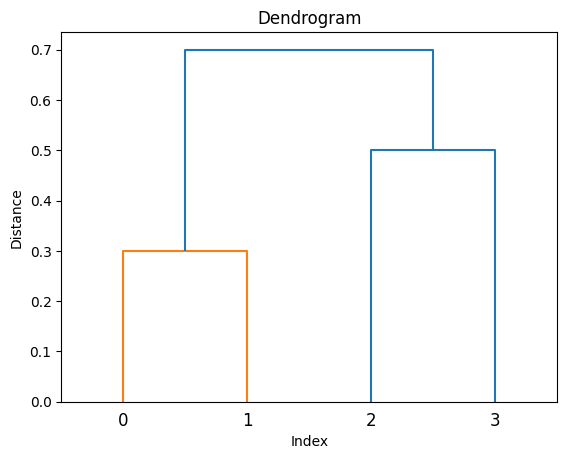

In [28]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy

def agglo_dendro(kmloss, mergeidx):
    idx = np.array(mergeidx)
    loss = np.array(kmloss[1:])  # Extract loss values
    after_idx = np.max(mergeidx, axis=1) + 1

    # Combine indices, loss values, and newly formed cluster indices
    matrix_with_column = np.column_stack((idx, loss.T, after_idx))

    # Plot the dendrogram
    plt.figure()
    dn = hierarchy.dendrogram(matrix_with_column)
    plt.title('Dendrogram')
    plt.xlabel('Index')
    plt.ylabel('Distance')
    plt.show()


kmloss = [0.1, 0.3, 0.5, 0.7]  # Example loss values
mergeidx = [(0, 1), (2, 3), (4, 5)]  # Example merge indices
agglo_dendro(kmloss, mergeidx)




## Assignment 4.
Write a function that computes the probability density function for a multivariate Gaussian distribution

$y = norm_pdf(X, mu, C)$

Input:
1. `X` is a n × d matrix of datapoints, 
2. `mu` is a vector with d length, which is the center of the Gaussians distribution 
3. `C` is the covariance matrix of the Gaussian distribution as a d × d matrix. 

Output:
the probability density function evaluated at all points in X as a length n vector:

In [30]:

def norm_pdf(X, mu, C):
    d = X.shape[1]
    
    # Compute the determinant and the inverse of the covariance matrix
    det_C = np.linalg.det(C)
    inv_C = np.linalg.inv(C)
    
    # compute coefficient
    coeff = 1 / (np.sqrt((2 * np.pi) ** d * det_C))
    
    # compute X_i - mu
    diff = X - mu
    
    # Compute the exponent term for each data point
    exponent = -0.5 * np.sum(diff @ inv_C * diff, axis=1)
    
    # Compute the PDF values
    pdf_values = coeff * np.exp(exponent)
    
    return pdf_values

X = np.array([[1, 2], [2, 3], [3, 4]])
mu = np.array([2, 3])
C = np.array([[1, 0], [0, 1]])

# Calculate the PDF at all points in X
pdf_values = norm_pdf(X, mu, C)
pdf_values

array([0.05854983, 0.15915494, 0.05854983])

In [108]:
from scipy.stats import multivariate_normal

def gmm(X, k, max_iter=100, init_kmeans=False, eps=1e-3, kmeans_func=None):
    """ Implements EM for Gaussian Mixture Models """
    n, d = X.shape  # Number of samples (n) and dimensions (d)
    
    # Initialize means using kmeans or randomly
    if init_kmeans:
        if kmeans_func is None:
            raise ValueError("kmeans function must be provided for initialization with kmeans")
        _, indices, _ = kmeans_func(X, k, 100)
    else:
        indices = np.random.choice(n, k, replace=False)
    mu = X[indices, :]  # Initial means

    # Initialize covariances to identity matrices
    sigma = [np.eye(d) for _ in range(k)]

    # Initialize weights to be equal
    pi = np.full(k, 1 / k)
    log_likelihood = 0

    def expectation(X, pi, mu, sigma):
        """ Calculate responsibilities (gamma) """
        gamma = np.zeros((n, k))
        for j in range(k):
            pdf = multivariate_normal(mean=mu[j], cov=sigma[j]).pdf(X)
            gamma[:, j] = pi[j] * pdf
        gamma /= gamma.sum(axis=1, keepdims=True)
        return gamma

    def maximization(X, gamma):
        """ Update pi, mu, and sigma """
        Nk = gamma.sum(axis=0)  # Sum responsibilities for each cluster
        pi = Nk / n
        mu = np.dot(gamma.T, X) / Nk[:, np.newaxis]
        sigma = [np.dot((gamma[:, j][:, np.newaxis] * (X - mu[j])).T, X - mu[j]) / Nk[j] for j in range(k)]
        return pi, mu, sigma

    for l in range(max_iter):
        gamma = expectation(X, pi, mu, sigma)
        prev_log_likelihood = log_likelihood
        log_likelihood = np.sum(np.log(np.dot(gamma, pi)))
        pi, mu, sigma = maximization(X, gamma)
        if np.abs(log_likelihood - prev_log_likelihood) < eps:
            break
        print(f"number of iterations: {l+1}, log likelihood: {log_likelihood}")
    
    return pi, mu, sigma, log_likelihood, gamma


## Assignment 9.


In [83]:
import scipy.io
data = scipy.io.loadmat("/Users/yue/tub/Lab-ML/problem_set1/data/usps.mat")
data.keys()

usps_X = np.array(data.get('data_patterns'))
usps_Y = np.array(data.get('data_labels'))

usps_Y.shape, usps_X.shape

((10, 2007), (256, 2007))

In [90]:
# Assuming kmeans function is defined as:
# def kmeans(X, k, max_iter=100):
#     ...

# Parameters
k = 10
max_iter = 100

# Apply k-means clustering
mu_kmeans, r_kmeans, loss_kmeans = kmeans(usps_X.T, k, max_iter)

# Print the results
print("K-Means Clustering Results:")
print("Cluster Centroids (mu):", mu_kmeans)
print("Cluster Memberships (r):", r_kmeans)
print("Loss:", loss_kmeans)


K-Means Clustering Results:
Cluster Centroids (mu): [[-0.98142655 -0.94376691 -0.86455887 ... -0.80226907 -0.92322728
  -0.97998711]
 [-0.98269794 -0.94483976 -0.86735959 ... -0.96351617 -0.99132265
  -0.99819203]
 [-0.99543724 -0.98463051 -0.94977035 ... -0.90629804 -0.96751116
  -0.99109173]
 ...
 [-0.99329601 -0.97951265 -0.95337133 ... -0.98080246 -0.9975032
  -0.99987749]
 [-0.9864613  -0.95222123 -0.88201119 ... -0.99815335 -0.99957686
  -0.99996493]
 [-0.99679934 -0.98921956 -0.9688298  ... -0.97913854 -0.98009607
  -0.98336471]]
Cluster Memberships (r): [7 9 0 ... 1 5 4]
Loss: 11970.115701473474


In [111]:
# Assuming em_gmm function is defined as:
# def em_gmm(X, k, max_iter=100, init_kmeans=False, tol=1e-5):
#     ...

# Apply EM-GMM clustering
pi_gmm, mu_gmm, sigma_gmm, loglik_gmm, gamma = gmm(usps_X.T, 2, init_kmeans=False, kmeans_func=kmeans)

# Print the results
print("EM-GMM Clustering Results:")
print("Mixture Proportions (pi):", pi_gmm)
print("Cluster Centroids (mu):", mu_gmm)
print("Covariance Matrices (sigma):", sigma_gmm)
print("Log-Likelihood:", -loglik_gmm)


number of iterations: 1, log likelihood: -1391.1463913838104
number of iterations: 2, log likelihood: -1212.5729317553225
number of iterations: 3, log likelihood: -1212.938739143307
EM-GMM Clustering Results:
Mixture Proportions (pi): [0.70752366 0.29247634]
Cluster Centroids (mu): [[-9.90501479e-01 -9.68205462e-01 -9.24912414e-01 -8.51124863e-01
  -7.45006822e-01 -6.08142097e-01 -4.32204563e-01 -2.63956956e-01
  -2.55449259e-01 -3.90369680e-01 -5.44831134e-01 -6.87836640e-01
  -8.13801477e-01 -9.04180175e-01 -9.58359325e-01 -9.87329228e-01
  -9.79790437e-01 -9.34701791e-01 -8.43947394e-01 -6.93986445e-01
  -5.02788414e-01 -3.05864893e-01 -9.60006739e-02  9.14680431e-02
   8.52211052e-02 -9.00703523e-02 -2.75406748e-01 -4.58142871e-01
  -6.54367332e-01 -8.15868408e-01 -9.16962620e-01 -9.72841183e-01
  -9.70471034e-01 -9.08515774e-01 -7.85758413e-01 -5.87984860e-01
  -3.70762636e-01 -2.16539021e-01 -9.35343684e-02  2.64407863e-02
   9.46968123e-03 -1.23370399e-01 -2.36222950e-01 -3.6655

In [115]:
_, usps_kmloss, usps_mergeidx = kmeans_agglo(usps_X.T, 10)



# Assignment 10.
1. Load dataset lab_data.npz. It contains the observations in X and whether this data point is an outlier in Y (−1 for outlier, +1 for inlier).